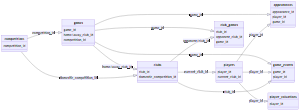


In [1]:
import pandas as pd

df_clubs = pd.read_csv('./data/clubs.csv')
df_game_lineups = pd.read_csv('./data/game_lineups.csv')
df_games = pd.read_csv('./data/games.csv')
df_players = pd.read_csv('./data/players.csv')
df_player_valuations = pd.read_csv('data/player_valuations.csv')

In [4]:
# Step 1: Merge df_game_lineups with df_games to get the date for each game
# Only select the 'game_id', 'date' columns from df_games to reduce merge size
game_lineups_with_date = pd.merge(df_game_lineups[['game_id', 'player_id', 'club_id']], 
                                  df_games[['game_id', 'date']], 
                                  on='game_id')

# Step 2: Merge with df_players to get player details
# Only select the 'player_id' and 'player_name' columns from df_players
player_game_lineups = pd.merge(game_lineups_with_date, 
                               df_players[['player_id', 'name']], 
                               on='player_id')

# Step 3: Merge with df_clubs to get club details
# Only select the 'club_id' and 'club_code' columns from df_clubs
player_club_date = pd.merge(player_game_lineups, 
                            df_clubs[['club_id', 'club_code']], 
                            on='club_id')

# Step 4: Sort by player and date
player_club_date_sorted = player_club_date.sort_values(by=['name', 'date'])

# Step 5: Remove consecutive club entries for each player and include club_id
def remove_consecutive_duplicates_with_date_include_club_id(df):
    # This function will iterate over the dataframe and only keep rows where the club changes
    # It will also collect the date of the change and include club_id
    changes = []
    last_club_code = None
    for _, row in df.iterrows():
        if row['club_code'] != last_club_code:
            changes.append({'club_id': row['club_id'], 'club_code': row['club_code'], 'date': row['date']})
            last_club_code = row['club_code']
    return pd.DataFrame(changes)

# Apply the function to each player's data
player_club_changes = player_club_date_sorted.groupby('player_id').apply(remove_consecutive_duplicates_with_date_include_club_id).reset_index()

# Drop the extra index column
player_club_changes.drop('level_1', axis=1, inplace=True)

C:\Users\ellio\AppData\Local\Temp\ipykernel_50628\2458863057.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  player_club_changes = player_club_date_sorted.groupby('player_id').apply(remove_consecutive_duplicates_with_date_include_club_id).reset_index()


In [5]:
# Ensure the 'date' column is in datetime format for both dataframes
player_club_changes['date'] = pd.to_datetime(player_club_changes['date'])
df_player_valuations['date'] = pd.to_datetime(df_player_valuations['date'])

# Sort player_valuations by player_id and date to ensure the latest past valuation can be found
df_player_valuations = df_player_valuations.sort_values(by=['player_id', 'date'])

# Function to get the latest market value before the change date
def get_latest_valuation_before_change(row, valuations_df):
    player_id = row['player_id']
    change_date = row['date']
    # Filter valuations for the player and valuation dates before the change date
    past_valuations = valuations_df[(valuations_df['player_id'] == player_id) & 
                                    (valuations_df['date'] <= change_date)]
    if not past_valuations.empty:
        # Get the latest valuation before the change date
        return past_valuations.iloc[-1]['market_value_in_eur']
    else:
        # If no past valuation is found, return NaN or a default value
        return float('nan')

# Apply the function to each row in player_club_changes
player_club_changes['transfer_value'] = player_club_changes.apply(
    lambda row: get_latest_valuation_before_change(row, df_player_valuations), axis=1)

# Merge the player_club_changes with df_players to get the player names and include club_id
final_player_club_history = pd.merge(df_players[['player_id', 'name']], 
                                     player_club_changes[['player_id', 'club_id', 'club_code', 'date', 'transfer_value']], 
                                     on='player_id')

# No need to explode since we are making each transfer its own row
# Convert 'date' to datetime
final_player_club_history['date'] = pd.to_datetime(final_player_club_history['date'])

final_player_club_history.head()

,player_id,name,club_id,club_code,date,transfer_value
0,10,Miroslav Klose,398,lazio-rom,2013-08-18,2000000.0
1,26,Roman Weidenfeller,16,borussia-dortmund,2013-07-27,5000000.0
2,65,Dimitar Berbatov,931,fc-fulham,2013-08-17,5000000.0
3,65,Dimitar Berbatov,162,as-monaco,2014-02-09,3500000.0
4,65,Dimitar Berbatov,1091,paok-thessaloniki,2015-09-12,1000000.0


In [7]:
final_player_club_history[final_player_club_history['name'] == 'Cristiano Ronaldo']


,player_id,name,club_id,club_code,date,transfer_value
1025,8198,Cristiano Ronaldo,418,real-madrid,2013-08-18,100000000.0
1026,8198,Cristiano Ronaldo,506,juventus-turin,2018-08-18,100000000.0
1027,8198,Cristiano Ronaldo,985,manchester-united,2021-09-11,45000000.0


In [2]:
final_player_club_history.to_csv('./data/player_club_history.csv')

NameError: name 'final_player_club_history' is not defined

In [23]:
import numpy as np
df_player_history = pd.read_csv('./data/player_club_history.csv')
df_appearances = pd.read_csv('data/appearances.csv')

In [15]:
def player_stats(player_name, season):
    
    df = df_appearances.merge(df_games, on=['game_id'], how='left')
    df = df[df['player_name'] == player_name]  
    df = df[df['season'] == season]
    
    if (df.shape[0] == 0):
        Out = [(np.nan, player_name, season, 0, 0, 0, 0, 0, 0, 0)]
        out_df = pd.DataFrame(data=Out, columns=['player_id', 'player_name', 'season', 'goals', 'games',
                                                 'assists', 'minutes_played', 'goals_for', 'goals_against', 'clean_sheet'])
        return out_df
    
    else:
        
        df["goals_for"] = df.apply(lambda row: row['home_club_goals'] if row['home_club_id'] == row['player_club_id'] 
                      else row['away_club_goals'] if row['away_club_id'] == row['player_club_id'] 
                      else np.nan, axis=1)
        df["goals_against"] = df.apply(lambda row: row['away_club_goals'] if row['home_club_id'] == row['player_club_id'] 
                      else row['home_club_goals'] if row['away_club_id'] == row['player_club_id'] 
                      else np.nan, axis=1)
        df['clean_sheet'] = df.apply(lambda row: 1 if row['goals_against'] == 0
                      else 0 if row['goals_against'] > 0
                      else np.nan, axis=1)
        
        df = df.groupby(['player_id', "player_name", "season"], as_index=False).agg({'goals': 'sum', 'game_id': 'nunique', 
                                                                      'assists': 'sum', 'minutes_played': 'sum', 'goals_for': 'sum',
                                                                      'goals_against': 'sum', 'clean_sheet': 'sum'})
        out_df = df.rename(columns={'game_id': 'games'})
        
        return out_df

In [17]:
player_stats('Cristiano Ronaldo', 2022)

,player_id,player_name,season,goals,games,assists,minutes_played,goals_for,goals_against,clean_sheet
0,8198,Cristiano Ronaldo,2022,3,16,2,1051,22,15,8


In [24]:
def all_players_season_stats():
    # Merge appearances with games and clubs to include club information
    df_merged = df_appearances.merge(df_games, on='game_id', how='left').merge(df_clubs, left_on='player_club_id', right_on='club_id', how='left')
    
    # Calculate goals for and against, and clean sheets
    df_merged["goals_for"] = df_merged.apply(lambda row: row['home_club_goals'] if row['home_club_id'] == row['player_club_id'] 
                                             else row['away_club_goals'] if row['away_club_id'] == row['player_club_id'] 
                                             else np.nan, axis=1)
    df_merged["goals_against"] = df_merged.apply(lambda row: row['away_club_goals'] if row['home_club_id'] == row['player_club_id'] 
                                                 else row['home_club_goals'] if row['away_club_id'] == row['player_club_id'] 
                                                 else np.nan, axis=1)
    df_merged['clean_sheet'] = df_merged.apply(lambda row: 1 if row['goals_against'] == 0
                                               else 0 if row['goals_against'] > 0
                                               else np.nan, axis=1)
    
    # Group by player, season, and club to aggregate stats
    grouped_df = df_merged.groupby(['player_id', 'player_name', 'season', 'club_code', 'club_id'], as_index=False).agg({
        'goals': 'sum', 
        'game_id': 'nunique', 
        'assists': 'sum', 
        'minutes_played': 'sum', 
        'goals_for': 'sum',
        'goals_against': 'sum', 
        'clean_sheet': 'sum'
    }).rename(columns={'game_id': 'games'})
    
    return grouped_df

In [25]:
player_season_stat = all_players_season_stats()

In [26]:
player_season_stat.head()

,player_id,player_name,season,club_code,club_id,goals,games,assists,minutes_played,goals_for,goals_against,clean_sheet
0,10,Miroslav Klose,2012,lazio-rom,398.0,16,36,3,2585,55,29,16
1,10,Miroslav Klose,2013,lazio-rom,398.0,8,29,5,2220,38,43,10
2,10,Miroslav Klose,2014,lazio-rom,398.0,16,40,9,2289,77,40,15
3,10,Miroslav Klose,2015,lazio-rom,398.0,8,31,8,1714,42,41,9
4,26,Roman Weidenfeller,2012,borussia-dortmund,16.0,0,49,0,4401,109,56,13


In [27]:
def combine_player_stats_and_valuations(player_season_stat, player_valuations):
    # Convert 'season' to datetime to match with the valuation dates
    # Assuming the season ends on May 31st of the following year
    player_season_stat['season_end_date'] = pd.to_datetime((player_season_stat['season'] + 1).astype(str) + '-05-31')
    
    # Prepare player_valuations by ensuring 'date' is in datetime format
    player_valuations['date'] = pd.to_datetime(player_valuations['date'])
    
    # Initialize an empty DataFrame to store the combined data
    combined_data = []

    # Iterate over each row in player_season_stat to find the corresponding valuation
    for index, row in player_season_stat.iterrows():
        player_id = row['player_id']
        season_end_date = row['season_end_date']
        
        # Filter valuations for the player and valuation dates before the season end date
        filtered_valuations = player_valuations[(player_valuations['player_id'] == player_id) & 
                                                (player_valuations['date'] <= season_end_date)]
        
        # Sort the filtered valuations by date and select the last one (closest to season end)
        latest_valuation = filtered_valuations.sort_values(by='date', ascending=False).head(1)
        
        # If there's a valuation, extract the market value; otherwise, set it as NaN
        market_value = latest_valuation['market_value_in_eur'].values[0] if not latest_valuation.empty else float('nan')
        
        # Append the combined data with the market value
        combined_data.append(row.tolist() + [market_value])
    
    # Define the column names for the combined DataFrame
    combined_columns = player_season_stat.columns.tolist() + ['season_end_valuation']
    
    # Create a DataFrame from the combined data
    combined_df = pd.DataFrame(combined_data, columns=combined_columns)
    
    return combined_df

In [28]:
player_stat_valuations = combine_player_stats_and_valuations(player_season_stat, df_player_valuations)
player_stat_valuations.head()



,player_id,player_name,season,club_code,club_id,goals,games,assists,minutes_played,goals_for,goals_against,clean_sheet,season_end_date,season_end_valuation
0,10,Miroslav Klose,2012,lazio-rom,398.0,16,36,3,2585,55,29,16,2013-05-31,4000000.0
1,10,Miroslav Klose,2013,lazio-rom,398.0,8,29,5,2220,38,43,10,2014-05-31,1000000.0
2,10,Miroslav Klose,2014,lazio-rom,398.0,16,40,9,2289,77,40,15,2015-05-31,1000000.0
3,10,Miroslav Klose,2015,lazio-rom,398.0,8,31,8,1714,42,41,9,2016-05-31,1000000.0
4,26,Roman Weidenfeller,2012,borussia-dortmund,16.0,0,49,0,4401,109,56,13,2013-05-31,4000000.0


In [29]:
player_stat_valuations.dropna(subset=['season_end_valuation'], inplace=True)

In [30]:
player_stat_valuations.drop(columns=['season_end_date'], inplace=True)
player_stat_valuations.head()


,player_id,player_name,season,club_code,club_id,goals,games,assists,minutes_played,goals_for,goals_against,clean_sheet,season_end_valuation
0,10,Miroslav Klose,2012,lazio-rom,398.0,16,36,3,2585,55,29,16,4000000.0
1,10,Miroslav Klose,2013,lazio-rom,398.0,8,29,5,2220,38,43,10,1000000.0
2,10,Miroslav Klose,2014,lazio-rom,398.0,16,40,9,2289,77,40,15,1000000.0
3,10,Miroslav Klose,2015,lazio-rom,398.0,8,31,8,1714,42,41,9,1000000.0
4,26,Roman Weidenfeller,2012,borussia-dortmund,16.0,0,49,0,4401,109,56,13,4000000.0


In [31]:
# Merge player_stat_valuations with df_players to append position and sub-position
player_stat_valuations = pd.merge(player_stat_valuations, df_players[['player_id', 'position', 'sub_position']], on='player_id', how='left')


In [32]:
df_competitions = pd.read_csv('data/competitions.csv')

In [33]:
# Assuming df_clubs has columns 'club_id' and 'domestic_competition_id' for the league information
player_history = pd.merge(player_stat_valuations, df_clubs[['club_id', 'domestic_competition_id']], on='club_id', how='left')

# Rename 'domestic_competition_id' to 'league' for clarity
player_history.rename(columns={'domestic_competition_id': 'league'}, inplace=True)

In [34]:
player_history.head()

,player_id,player_name,season,club_code,club_id,goals,games,assists,minutes_played,goals_for,goals_against,clean_sheet,season_end_valuation,position,sub_position,league
0,10,Miroslav Klose,2012,lazio-rom,398.0,16,36,3,2585,55,29,16,4000000.0,Attack,Centre-Forward,IT1
1,10,Miroslav Klose,2013,lazio-rom,398.0,8,29,5,2220,38,43,10,1000000.0,Attack,Centre-Forward,IT1
2,10,Miroslav Klose,2014,lazio-rom,398.0,16,40,9,2289,77,40,15,1000000.0,Attack,Centre-Forward,IT1
3,10,Miroslav Klose,2015,lazio-rom,398.0,8,31,8,1714,42,41,9,1000000.0,Attack,Centre-Forward,IT1
4,26,Roman Weidenfeller,2012,borussia-dortmund,16.0,0,49,0,4401,109,56,13,4000000.0,Goalkeeper,Goalkeeper,L1


In [38]:
# Calculate the age of the player during the season
# First, merge player_history with df_players to get the date_of_birth
player_history = pd.merge(player_history, df_players[['player_id', 'date_of_birth']], on='player_id', how='left')

# Convert 'date_of_birth' and 'season' to datetime objects
player_history['date_of_birth'] = pd.to_datetime(player_history['date_of_birth'])
# Assuming the season starts on July 1st of the 'season' year
player_history['season_start_date'] = pd.to_datetime(player_history['season'].astype(str) + '-07-01')

# Calculate age by subtracting the date_of_birth from the season_start_date and converting to days, then divide by 365.25 to get years
player_history['age'] = ((player_history['season_start_date'] - player_history['date_of_birth']) / np.timedelta64(1, 'D') / 365.25)

# Use np.floor to round down the age and handle NaN values gracefully
player_history['age'] = np.floor(player_history['age']).astype('Int64')

# Drop the 'date_of_birth' and 'season_start_date' columns as they are no longer needed
player_history.drop(columns=['date_of_birth', 'season_start_date'], inplace=True)

player_history.head()

,player_id,player_name,season,club_code,club_id,goals,games,assists,minutes_played,goals_for,goals_against,clean_sheet,season_end_valuation,position,sub_position,league,age
0,10,Miroslav Klose,2012,lazio-rom,398.0,16,36,3,2585,55,29,16,4000000.0,Attack,Centre-Forward,IT1,34
1,10,Miroslav Klose,2013,lazio-rom,398.0,8,29,5,2220,38,43,10,1000000.0,Attack,Centre-Forward,IT1,35
2,10,Miroslav Klose,2014,lazio-rom,398.0,16,40,9,2289,77,40,15,1000000.0,Attack,Centre-Forward,IT1,36
3,10,Miroslav Klose,2015,lazio-rom,398.0,8,31,8,1714,42,41,9,1000000.0,Attack,Centre-Forward,IT1,37
4,26,Roman Weidenfeller,2012,borussia-dortmund,16.0,0,49,0,4401,109,56,13,4000000.0,Goalkeeper,Goalkeeper,L1,31


In [39]:
lineups_with_clubs = pd.merge(df_game_lineups, df_clubs[['club_id', 'club_code']], on='club_id')



# Merge the updated lineups with players to include player_code

lineups_with_codes = pd.merge(lineups_with_clubs, df_players[['player_id', 'player_code']], on='player_id')

In [40]:
df_club_games = pd.read_csv('data/club_games.csv')
df_club_games.head()

,game_id,club_id,own_goals,own_position,own_manager_name,opponent_id,opponent_goals,opponent_position,opponent_manager_name,hosting,is_win
0,2320450,1468,0,NaN,Holger Bachthaler,24,2,NaN,Armin Veh,Home,0
1,2320460,1,3,NaN,Jürgen Luginger,86,1,NaN,Robin Dutt,Home,1
2,2320472,2036,4,NaN,Frank Schmidt,72,5,NaN,Alexander Schmidt,Home,0
3,2321044,16,2,1.0,Jürgen Klopp,23,1,15.0,Torsten Lieberknecht,Home,1
4,2321060,23,0,18.0,Torsten Lieberknecht,24,2,11.0,Armin Veh,Home,0


In [41]:
# Merge lineups_with_codes with df_club_games to include own_position
lineups_with_positions = pd.merge(lineups_with_codes, df_club_games[['game_id', 'club_id', 'own_position']], on=['game_id', 'club_id'])

# Now lineups_with_positions includes player_code, club_code, and own_position